# Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm
import scipy
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


cuda


In [2]:
"""The :mod:`sklearn.kernel_regressor` module implements the Kernel Regressor.
"""
# Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
#
# License: BSD 3 clause

import numpy as np

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples, m]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X_test):
        """Predict target values for X_test, size m*n_features.

        Parameters
        ----------
        X_test : array-like of shape = [n_te_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_te_samples, m]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X_test, metric=self.kernel, gamma=self.gamma)
        # K.shape=[n_tr_samples, n_te_samples]
        # self.X.shape=[n_tr_samples, n_features]
        # self.y.shape=[n_tr_samples, m]
        if self.y.ndim==1:
            ncol=1
        else:
            ncol=self.y.shape[1]
        numerator=(np.transpose(self.y).dot(K)).reshape(ncol,K.shape[1])
        return np.transpose(numerator / K.sum(axis=0))

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/DPLM/aistats_rebuttal/'

Mounted at /content/drive


In [4]:
def setting(n, p, p1, noise=1,npseed=0):
    np.random.seed(npseed)
    data=np.empty((n, p))

    for i in range(n):
        data[i,:] = np.random.normal(0,1, size = (1, p))

    beta1 = np.ones(p1)
    # beta2 = torch.cat((torch.ones(1), torch.zeros(p-p1-1)), dim=0)
    beta2 = np.zeros(p-p1)
    beta=np.concatenate((beta1,beta2),axis=0)

    y = np.matmul(data, beta).reshape(n, 1) + np.random.normal(0, noise, size = (n, 1))


    return y, data,beta

def newset(y, X, T):
    new_y = torch.tensor(np.concatenate((y, X), axis=1)).float()
    new_data = torch.tensor(T).float()
    return new_y, new_data

In [5]:
def simulations(Nrun=20,split_size=0.2,sigma=1,n=1000,p=3000,p1=300,lam=2,alpha=0.05,verbose=1,lamj=2):
  beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plmnn, beta_plmNW, beta_plmlasso, beta_dblasso=[],[],[],[],[],[],[],[]
  y_truth, y_ols,y_lasso, y_lassols, y_plmnn,y_plmNW,y_plmlasso, y_dblasso=[],[],[],[],[],[],[],[]
  y_truth_te, y_ols_te,y_lasso_te, y_lassols_te, y_plmnn_te,y_plmNW_te,y_plmlasso_te, y_dblasso_te=[],[],[],[],[],[],[],[]
  conf_ols,conf_lassols,conf_plmnn,conf_plmNW,conf_plmlasso,conf_dblasso=[],[],[],[],[],[]
  time_plmnn,time_plmNW,time_plmlasso,time_dblasso=[],[],[],[]

  for i in range(Nrun):
      y, X,beta = setting(n=n, p=p, p1=p1, noise=sigma, npseed=i)
      np.random.seed(i)
      torch.manual_seed(i)

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=i)
      print(y_train.shape, y_test.shape)
      # LASSO
      lasso = Lasso(alpha = lam,fit_intercept=False) # lasso: alpha=1 prediction bad; alpha=0.1 no zero; mixture 0.15
      lasso.fit(X_train, y_train)
      lasso_coef=lasso.coef_
      print('Run ',i,', Lasso selects ',sum(lasso_coef!=0),' features.')
      beta_truth.append(beta[lasso_coef!=0])
      y_truth.append(y_train.flatten())
      y_truth_te.append(y_test.flatten())

      beta_lasso.append(lasso_coef[lasso_coef!=0])
      y_lasso.append(X_train.dot(lasso_coef))
      y_lasso_te.append(X_test.dot(lasso_coef))

      new_p1 = sum(lasso_coef!=0)
      Z_train = X_train[:, lasso_coef!=0]
      T_train = X_train[:, lasso_coef==0]
      Z_test = X_test[:, lasso_coef!=0]
      T_test = X_test[:, lasso_coef==0]

      # OLS if low dimension
      if n>p:
        ols = sm.OLS(y_train, X_train).fit()
        conf_ols.append(ols.conf_int(alpha=alpha, cols=None)[lasso_coef!=0])
        beta_ols.append(ols.params[lasso_coef!=0])
        y_ols.append(X_train.dot(ols.params))
        y_ols_te.append(X_test.dot(ols.params))

      # LASSO+OLS
      lasso_ols = sm.OLS(y_train, Z_train).fit()
      conf_lassols.append(lasso_ols.conf_int(alpha=alpha, cols=None))
      beta_lassols.append(lasso_ols.params)
      y_lassols.append(Z_train.dot(lasso_ols.params))
      y_lassols_te.append(Z_test.dot(lasso_ols.params))


      #LASSO+PLM-NN
      start_time = time.time()
      yZ_train_tensor, T_train_tensor = newset(y_train, Z_train, T_train)
      yZ_test_tensor, T_test_tensor = newset(y_test, Z_test, T_test)


      max_epoch = 1000
      lr = 2e-4
      D_in, H, D_out = p-new_p1, 1000, new_p1+1 #p1_new will be selected by lasso later
      batch_size = n

      Train_dataset = TensorDataset(T_train_tensor, yZ_train_tensor)
      trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
      Test_dataset = TensorDataset(T_test_tensor, yZ_test_tensor)
      testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=True)

      model = nn.Sequential(
          nn.Linear(D_in, H),
          nn.ReLU(),
          nn.Linear(H, D_out),
      )

      optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=2)
      criterion = nn.MSELoss()
      old_val_error=10000
      patience=0
      model.to(device)
      for epoch in range(max_epoch):
          for batch_T, batch_yZ in trainloader:
              batch_T, batch_yZ = batch_T.to(device), batch_yZ.to(device)
              optimizer.zero_grad()
              batch_yZ_pred = model(batch_T)
              batch_loss = criterion(batch_yZ_pred, batch_yZ)

              #print(epoch+1, '---', batch_loss)

              batch_loss.backward()
              optimizer.step()
          with torch.no_grad():
              T_test_tensor, yZ_test_tensor = T_test_tensor.to(device), yZ_test_tensor.to(device)
              yZ_pred = model(T_test_tensor)
              val_loss = criterion(yZ_pred, yZ_test_tensor)
          #early stopping
          if val_loss.item()<old_val_error:
              old_val_error=val_loss.item()
              patience=0
          else:
              patience+=1
          
          if patience>0:
              break

      whole_pred=model(T_train_tensor.to(device)).cpu().detach().numpy()
      mean_conditional_y=whole_pred[:,0]
      mean_conditional_Z=whole_pred[:,1:]
      whole_pred_te=model(T_test_tensor).cpu().detach().numpy()
      mean_conditional_y_te=whole_pred_te[:,0]
      mean_conditional_Z_te=whole_pred_te[:,1:]

      PLM_ols = sm.OLS(y_train-mean_conditional_y.reshape(-1,1), Z_train-mean_conditional_Z).fit()
      conf_plmnn.append(PLM_ols.conf_int(alpha=alpha, cols=None))
      beta_plmnn.append(PLM_ols.params)
      y_plmnn.append(mean_conditional_y.flatten()+(Z_train-mean_conditional_Z).dot(PLM_ols.params))
      y_plmnn_te.append(mean_conditional_y_te.flatten()+(Z_test-mean_conditional_Z_te).dot(PLM_ols.params))
      time_plmnn.append(time.time() - start_time)


      #DBLASSO
      start_time = time.time()
      C = np.zeros((p ,p))
      tau_2 = np.zeros((p))
      #each row in C is the trained coef_ of X_j
      r=list(range(p))
      for j in range(p):
          not_j=r[:j]+r[j+1:]
          lasso = Lasso(alpha=lamj,fit_intercept=False)
          lasso.fit(X_train[:,not_j], X_train[:,j].reshape(int(n*(1-split_size)), 1))
          node_beta=lasso.coef_
          # print(np.mean(node_beta!=0))
          C[j,not_j] = -node_beta
          C[j, j] = 1
          tau_2[j] = MSE(X_train[:,j],X_train[:,not_j].dot(node_beta))+lamj*sum(abs(node_beta))

      T_2 = np.diag(tau_2**(-1))
      Theta_hat = np.matmul(T_2, C)
      n_tr=len(X_train)
      db_lasso = lasso_coef + Theta_hat.dot(X_train.T.dot(y_train.reshape(-1,)-X_train.dot(lasso_coef))) /n_tr
      Sigma_hat = X_train.T.dot(X_train)/n_tr
      temp=np.diag((Theta_hat.dot(Sigma_hat)).dot(Theta_hat.T))
      c=scipy.stats.norm.ppf(1-alpha/2)*sigma*np.sqrt(temp/n_tr)
      conf_dblasso.append(np.vstack(((db_lasso-c)[lasso_coef!=0],(db_lasso+c)[lasso_coef!=0])).T)
      beta_dblasso.append(db_lasso[lasso_coef!=0])
      y_dblasso.append(X_train.dot(db_lasso))
      y_dblasso_te.append(X_test.dot(db_lasso))
      time_dblasso.append(time.time() - start_time)
      
      #LASSO+PLM-NW
      start_time = time.time()
      ml_y = KernelRegression() 
      ml_Z = KernelRegression() 

      ml_y.fit(T_train, y_train)
      ml_pred_y = ml_y.predict(T_train).reshape(-1,1)  #T_test
      ml_pred_y_te = ml_y.predict(T_test).reshape(-1,1)  #T_test

      ml_Z.fit(T_train, Z_train)
      ml_pred_Z = ml_Z.predict(T_train).reshape(ml_pred_y.shape[0],-1) #T_test
      ml_pred_Z_te = ml_Z.predict(T_test).reshape(ml_pred_y_te.shape[0],-1) #T_test

      ols_ml = sm.OLS(y_train-ml_pred_y, Z_train-ml_pred_Z).fit()
      cov_int = ols_ml.conf_int(alpha=alpha,cols=None)
      temp_beta = ols_ml.params
      temp_y_pred = (Z_train-ml_pred_Z).dot(temp_beta.reshape(-1,1))+ml_pred_y
      temp_y_pred_te = (Z_test-ml_pred_Z_te).dot(temp_beta.reshape(-1,1))+ml_pred_y_te

      conf_plmNW.append(cov_int)
      beta_plmNW.append(temp_beta)
      y_plmNW.append(temp_y_pred)
      y_plmNW_te.append(temp_y_pred_te)
      time_plmNW.append(time.time() - start_time)

      #LASSO+PLM-lasso
      start_time = time.time()
      ml_y = Lasso(alpha = 1)  #
      ml_Z = Lasso(alpha = 1)  #

      ml_y.fit(T_train, y_train)
      ml_pred_y = ml_y.predict(T_train).reshape(-1,1)  #T_test
      ml_pred_y_te = ml_y.predict(T_test).reshape(-1,1)  #T_test

      ml_Z.fit(T_train, Z_train)
      ml_pred_Z = ml_Z.predict(T_train).reshape(ml_pred_y.shape[0],-1) #T_test
      ml_pred_Z_te = ml_Z.predict(T_test).reshape(ml_pred_y_te.shape[0],-1) #T_test

      ols_ml = sm.OLS(y_train-ml_pred_y, Z_train-ml_pred_Z).fit()
      cov_int = ols_ml.conf_int(alpha=alpha,cols=None)
      temp_beta = ols_ml.params
      temp_y_pred = (Z_train-ml_pred_Z).dot(temp_beta.reshape(-1,1))+ml_pred_y
      temp_y_pred_te = (Z_test-ml_pred_Z_te).dot(temp_beta.reshape(-1,1))+ml_pred_y_te

      conf_plmlasso.append(cov_int)
      beta_plmlasso.append(temp_beta)
      y_plmlasso.append(temp_y_pred)
      y_plmlasso_te.append(temp_y_pred_te)
      time_plmlasso.append(time.time() - start_time)


      if verbose==1:
        #Output
        print('LASSO selects ',sum(lasso_coef!=0),' variables out of ', p1)
        print('Truth: ', beta[lasso_coef!=0]) #truth
        print('Lasso: ', lasso_coef[lasso_coef!=0]) #lasso
        print('OLS post-Lasso: ', lasso_ols.params)# lasso+ols
        print('DebiNet: ', PLM_ols.params)# lasso+PLM
        print('debised Lasso: ', db_lasso[lasso_coef!=0]) #debiased lasso

  return ([beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plmnn, beta_dblasso, beta_plmNW,beta_plmlasso],
          [y_truth, y_ols,y_lasso, y_lassols, y_plmnn, y_dblasso, y_plmNW, y_plmlasso],
          [beta_truth, conf_ols,conf_lassols,conf_plmnn,conf_dblasso,conf_plmNW,conf_plmlasso],
          [time_plmnn,time_dblasso,time_plmNW,time_plmlasso],
          [y_truth_te, y_ols_te,y_lasso_te, y_lassols_te, y_plmnn_te, y_dblasso_te, y_plmNW_te, y_plmlasso_te],db_lasso)

In [12]:
def est_plot(beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plmnn, beta_dblasso, beta_plmNW, beta_plmlasso,s=20,save=None):
  from matplotlib import pyplot as plt
  plt.plot(beta_truth)
  if len(beta_ols)!=0:
    plt.scatter(np.arange(len(beta_truth)),beta_ols,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_lasso,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_lassols,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_plmnn,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_dblasso,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_plmNW,s=s)
  #plt.scatter(np.arange(len(beta_truth)),beta_plmlasso,s=s)

  if len(beta_ols)!=0:
    plt.legend(['Truth','OLS','Lasso','OLS post-Lasso','DebiNet', 'debiased Lasso','NW post-Lasso'],loc='lower left')#,'PLM-Lasso post-Lasso'])
  else:
    plt.legend(['Truth','Lasso','OLS post-Lasso','DebiNet', 'debiased Lasso','NW post-Lasso'],loc='lower left')#,'PLM-Lasso post-Lasso'])
  plt.ylim(-3,3)
  if save:
    plt.savefig(path+save,format='pdf')
  plt.show()
  return None

def est_error_list(beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plmnn, beta_dblasso, beta_plmNW, beta_plmlasso):
  Nrun=len(beta_truth)
  if len(beta_ols)!=0:
    ols_record=[]
    for i in range(Nrun):
      ols_record.append(MSE(beta_truth[i],beta_ols[i]))
  
  lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=[],[],[],[],[],[]
  for i in range(Nrun):
    lasso_record.append(MSE(beta_truth[i],beta_lasso[i]))
    lassols_record.append(MSE(beta_truth[i],beta_lassols[i]))
    plmnn_record.append(MSE(beta_truth[i],beta_plmnn[i]))
    dblasso_record.append(MSE(beta_truth[i],beta_dblasso[i]))
    plmNW_record.append(MSE(beta_truth[i],beta_plmNW[i]))
    plmlasso_record.append(MSE(beta_truth[i],beta_plmlasso[i]))

  lasso_record=np.array(lasso_record)
  lassols_record=np.array(lassols_record)
  plmnn_record=np.array(plmnn_record)
  dblasso_record=np.array(dblasso_record)
  plmNW_record=np.array(plmNW_record)
  plmlasso_record=np.array(plmlasso_record)

  if len(beta_ols)!=0:
    ols_record=np.array(ols_record)
    return ols_record,lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record
  return lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record

def conf_plot(conf, run = 0,save=None):
  conf_nonzero = []
  conf_zero = []
  beta_nonzero=[]
  beta_zero=[]
  beta_truth=conf[0][run]


  if conf[1]!=[]:
    name = ['OLS','OLS post-Lasso', 'DebiNet', 'debiased Lasso','NW post-Lasso']#,'PLM-Lasso post-Lasso']
  else:
    name = ['OLS post-Lasso', 'DebiNet', 'debiased Lasso','NW post-Lasso']#,'PLM-Lasso post-Lasso']

  for i in range(1,len(conf)):
    if conf[i] !=[]:
      confi=conf[i][run]
      # print(confi[beta_truth!=0]);print(confi[beta_truth==0])
      conf_nonzero.append(np.mean(confi[beta_truth!=0][:,1]-confi[beta_truth!=0][:,0])/2)
      conf_zero.append(np.mean(confi[beta_truth==0][:,1]-confi[beta_truth==0][:,0])/2)
      beta_nonzero.append(np.mean(confi[beta_truth!=0]))
      beta_zero.append(np.mean(confi[beta_truth==0]))
      

  plt.errorbar(np.arange(len(beta_nonzero)), beta_nonzero, yerr=np.asarray(conf_nonzero).T,ls='none',uplims=True,lolims=True,marker='.')
  plt.errorbar(np.arange(len(beta_zero))+0.2, beta_zero, yerr=np.asarray(conf_zero).T,ls='none',uplims=True,lolims=True,marker='.')
  plt.axhline(y=0,linestyle='dashed',color='C1')
  plt.axhline(y=1,linestyle='dashed',color='C0')
  plt.xticks([r+0.1 for r in range(len(name))], name, fontsize=9)
  if save:
    plt.savefig(path+save,format='pdf')
  plt.show()
  return None

def cov_rate(conf):
  beta_truth = conf[0]
  Nrun=len(beta_truth)
  cov_rate,cov_len = [],[]
  for i in range(1, len(conf)):
    conff = conf[i]
    if conff !=[]:
      count = 0
      length = 0
      for j in range(Nrun):   
        conff_min, conff_max = conff[j][:,0], conff[j][:,1]
        # print(beta_truth[j], conff_min)
        mask = (beta_truth[j]>conff_min) * (beta_truth[j]<conff_max)
        count += np.mean(mask)
        length += np.mean(conff_max-conff_min)
      cov_rate.append(count/Nrun)  
      cov_len.append(length/Nrun)
  return cov_rate,cov_len

# High dimension High Sparsity



In [7]:
start=time.time() # 60min
outputs0=simulations(Nrun=50,split_size=0.2,sigma=1,n=1000,p=3000,p1=300,lam=2,alpha=0.05,verbose=0,lamj=2)
print(time.time()-start)

(800, 1) (200, 1)
Run  0 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  1 , Lasso selects  20  features.
(800, 1) (200, 1)
Run  2 , Lasso selects  19  features.
(800, 1) (200, 1)
Run  3 , Lasso selects  14  features.
(800, 1) (200, 1)
Run  4 , Lasso selects  15  features.
(800, 1) (200, 1)
Run  5 , Lasso selects  14  features.
(800, 1) (200, 1)
Run  6 , Lasso selects  20  features.
(800, 1) (200, 1)
Run  7 , Lasso selects  15  features.
(800, 1) (200, 1)
Run  8 , Lasso selects  18  features.
(800, 1) (200, 1)
Run  9 , Lasso selects  21  features.
(800, 1) (200, 1)
Run  10 , Lasso selects  15  features.
(800, 1) (200, 1)
Run  11 , Lasso selects  16  features.
(800, 1) (200, 1)
Run  12 , Lasso selects  23  features.
(800, 1) (200, 1)
Run  13 , Lasso selects  25  features.
(800, 1) (200, 1)
Run  14 , Lasso selects  18  features.
(800, 1) (200, 1)
Run  15 , Lasso selects  13  features.
(800, 1) (200, 1)
Run  16 , Lasso selects  13  features.
(800, 1) (200, 1)
Run  17 , Lasso selects

In [8]:
### estimation error
lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs0[0][0],[],outputs0[0][2],outputs0[0][3],outputs0[0][4],outputs0[0][5],outputs0[0][6],outputs0[0][7])
print('Lasso estimation error: ',lasso_record)
print('LassoOLS estimation error: ',lassols_record)
print('dbLasso estimation error: ',dblasso_record)
print('LassoPLM-NN estimation error: ',plmnn_record)
print('LassoPLM-NW estimation error: ',plmNW_record)
print('LassoPLM-Lasso estimation error: ',plmlasso_record)

Lasso estimation error:  [0.53919335 0.58394743 0.5492104  0.54766864 0.47100724 0.5347331
 0.60060513 0.44318262 0.60115344 0.54586186 0.59677469 0.58803292
 0.4863577  0.50148283 0.40602692 0.61480549 0.56975915 0.52788403
 0.53985709 0.56913942 0.48848199 0.54663714 0.53718218 0.53584212
 0.61777351 0.54719893 0.44170332 0.51917821 0.52528285 0.43549198
 0.68199632 0.54682365 0.56804332 0.55211043 0.53586055 0.50423878
 0.51658979 0.54463789 0.42613691 0.46125254 0.6137757  0.48162985
 0.51478645 0.5260834  0.46256697 0.50423691 0.55986177 0.57986664
 0.56358728 0.68361754]
LassoOLS estimation error:  [1.71778434 1.24353699 1.31914071 0.92248497 1.12902902 1.34732775
 1.07035111 1.43200498 1.54925901 1.23473314 1.14366624 0.98110107
 1.29919696 1.07892494 1.95144874 1.69751205 1.71139549 1.78896986
 1.27397381 1.61521658 1.79867016 0.9477924  1.75371849 2.29673133
 0.95115653 1.64376965 1.59926139 1.54747263 1.71871585 1.30189618
 1.24512066 1.33947239 1.05159122 1.08210856 1.193168

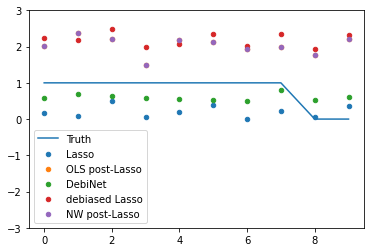



Lasso estimation error mean/STD:  0.536783167128362 0.05845292435034476
LassoOLS estimation error mean/STD:  1.4021098101304714 0.3085076910135192
dbLasso estimation error mean/STD:  2.0185052017283134 0.29001055252616176
LassoPLM-NN estimation error mean/STD:  0.42062998711894084 0.4181678805291729
LassoPLM-NW estimation error mean/STD:  1.397792096846464 0.3065049588976291
LassoPLM-Lasso estimation error mean/STD:  0.5589596599417118 0.17631614599399198




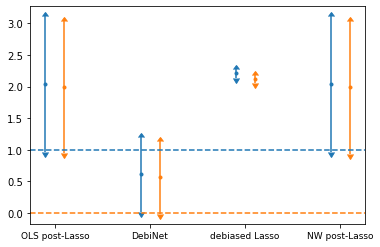



LassoOLS coverage:  0.5576233970199646  with width  2.1514329213735324
LassoPLM-NN coverage:  0.8295398443153591  with width  1.618487672986311
dbLasso coverage:  0.0  with width  0.13789324136206163
LassoPLM-NW coverage:  0.559734278256704  with width  2.1505734507945617
LassoPLM-Lasso coverage:  0.7521676953481304  with width  1.6456910439324117


Lasso prediction error mean/STD:  286.2176876020596 9.765923675088981
LassoOLS prediction error mean/STD:  233.36336190760372 11.050155735099594
dbLasso prediction error:  4998.749947335721 364.66894005292284
LassoPLM-NN prediction error:  136.37609773504144 54.195310964560655
LassoPLM-NW prediction error:  229.19338728501572 10.85967883523156
LassoPLM-Lasso prediction error:  136.42884982610124 8.296485798865202


Lasso generalization error mean/STD:  296.1116598978368 25.615042048985472
LassoOLS generalization error mean/STD:  308.4398793872588 25.240715167319983
dbLasso generalization error mean/STD:  1100.6801979883933 111.52971246130

In [13]:
est_plot(outputs0[0][0][0],[],outputs0[0][2][0],outputs0[0][3][0],outputs0[0][4][0],outputs0[0][5][0],outputs0[0][6][0],outputs0[0][7][0],save='high1.pdf')
print('\n')

### estimation error
lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs0[0][0],[],outputs0[0][2],outputs0[0][3],outputs0[0][4],outputs0[0][5],outputs0[0][6],outputs0[0][7])
print('Lasso estimation error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS estimation error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso estimation error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN estimation error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW estimation error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso estimation error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

conf_plot(outputs0[2][:-1],save='highconfidence1.pdf')
print('\n')

### coverage
print('LassoOLS coverage: ',cov_rate(outputs0[2])[0][0],' with width ',cov_rate(outputs0[2])[1][0])
print('LassoPLM-NN coverage: ',cov_rate(outputs0[2])[0][1],' with width ',cov_rate(outputs0[2])[1][1])
print('dbLasso coverage: ',cov_rate(outputs0[2])[0][2],' with width ',cov_rate(outputs0[2])[1][2])
print('LassoPLM-NW coverage: ',cov_rate(outputs0[2])[0][3],' with width ',cov_rate(outputs0[2])[1][3])
print('LassoPLM-Lasso coverage: ',cov_rate(outputs0[2])[0][4],' with width ',cov_rate(outputs0[2])[1][4])
print('\n')

### prediction error
lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs0[1][0],[],outputs0[1][2],outputs0[1][3],outputs0[1][4],outputs0[1][5],outputs0[1][6],outputs0[1][7])
print('Lasso prediction error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS prediction error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso prediction error: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN prediction error: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW prediction error: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso prediction error: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

### generalization error
lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs0[4][0],[],outputs0[4][2],outputs0[4][3],outputs0[4][4],outputs0[4][5],outputs0[4][6],outputs0[4][7])
print('Lasso generalization error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS generalization error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso generalization error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN generalization error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW generalization error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso generalization error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

### time
print('LassoPLM-NN time: ',np.mean(outputs0[3][0]), np.std(outputs0[3][0]))
print('dbLasso time: ',np.mean(outputs0[3][1]), np.std(outputs0[3][1]))
print('LassoPLM-NW time: ',np.mean(outputs0[3][2]), np.std(outputs0[3][2]))
print('LassoPLM-Lasso time: ',np.mean(outputs0[3][3]), np.std(outputs0[3][3]))

# High dimension Low Sparsity

In [10]:
start=time.time() # 60min
outputs1=simulations(Nrun=50,split_size=0.2,sigma=1,n=1000,p=3000,p1=10,lam=0.5,alpha=0.05,verbose=0,lamj=0.5)
print(time.time()-start)

(800, 1) (200, 1)
Run  0 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  1 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  2 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  3 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  4 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  5 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  6 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  7 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  8 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  9 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  10 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  11 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  12 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  13 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  14 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  15 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  16 , Lasso selects  10  features.
(800, 1) (200, 1)
Run  17 , Lasso selects

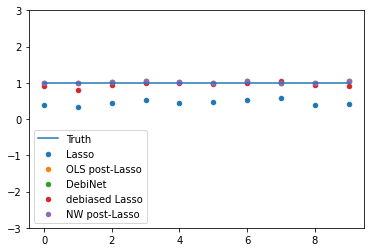



Lasso estimation error mean/STD:  0.26449846390353626 0.027086884355774526
LassoOLS estimation error mean/STD:  0.0011404242302325697 0.00040628152691524346
dbLasso estimation error mean/STD:  0.004136383391036785 0.0016298716434615561
LassoPLM-NN estimation error mean/STD:  0.00115519775450629 0.0004209470542800493
LassoPLM-NW estimation error mean/STD:  0.0011394854376432465 0.00040903004044341474
LassoPLM-Lasso estimation error mean/STD:  0.0011394928586415216 0.0004090787652200937




/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


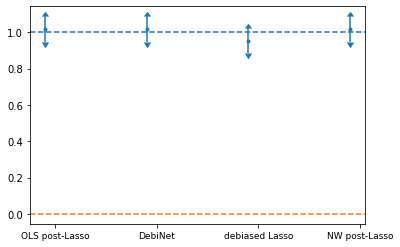



LassoOLS coverage:  0.9579999999999995  with width  0.13994005744487667
LassoPLM-NN coverage:  0.9559999999999995  with width  0.1403247117073249
dbLasso coverage:  0.7019999999999998  with width  0.138684031158789
LassoPLM-NW coverage:  0.9599999999999995  with width  0.1399597476985783
LassoPLM-Lasso coverage:  0.9599999999999995  with width  0.13996186738771896


Lasso prediction error mean/STD:  3.531164600858205 0.13070791599181197
LassoOLS prediction error mean/STD:  0.9917339761951002 0.05695979817000977
dbLasso prediction error:  55.02368762997346 3.2953066447574493
LassoPLM-NN prediction error:  0.988851881641705 0.05642580209474236
LassoPLM-NW prediction error:  0.9750675939992797 0.056244898615907694
LassoPLM-Lasso prediction error:  0.9907106016784221 0.057140635476515315


Lasso generalization error mean/STD:  3.633829144389713 0.41149672797641834
LassoOLS generalization error mean/STD:  1.0094631312343225 0.08567278486677025
dbLasso generalization error mean/STD:  14.00

In [14]:
est_plot(outputs1[0][0][0],[],outputs1[0][2][0],outputs1[0][3][0],outputs1[0][4][0],outputs1[0][5][0],outputs1[0][6][0],outputs1[0][7][0],save='high2.pdf')
print('\n')

### estimation error
lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs1[0][0],[],outputs1[0][2],outputs1[0][3],outputs1[0][4],outputs1[0][5],outputs1[0][6],outputs1[0][7])
print('Lasso estimation error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS estimation error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso estimation error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN estimation error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW estimation error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso estimation error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')



conf_plot(outputs1[2][:-1],save='highconfidence2.pdf')
print('\n')

### coverage
print('LassoOLS coverage: ',cov_rate(outputs1[2])[0][0],' with width ',cov_rate(outputs1[2])[1][0])
print('LassoPLM-NN coverage: ',cov_rate(outputs1[2])[0][1],' with width ',cov_rate(outputs1[2])[1][1])
print('dbLasso coverage: ',cov_rate(outputs1[2])[0][2],' with width ',cov_rate(outputs1[2])[1][2])
print('LassoPLM-NW coverage: ',cov_rate(outputs1[2])[0][3],' with width ',cov_rate(outputs1[2])[1][3])
print('LassoPLM-Lasso coverage: ',cov_rate(outputs1[2])[0][4],' with width ',cov_rate(outputs1[2])[1][4])
print('\n')

### prediction error
lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs1[1][0],[],outputs1[1][2],outputs1[1][3],outputs1[1][4],outputs1[1][5],outputs1[1][6],outputs1[1][7])
print('Lasso prediction error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS prediction error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso prediction error: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN prediction error: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW prediction error: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso prediction error: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')


### generalization error
lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs1[4][0],[],outputs1[4][2],outputs1[4][3],outputs1[4][4],outputs1[4][5],outputs1[4][6],outputs1[4][7])
print('Lasso generalization error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS generalization error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso generalization error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN generalization error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW generalization error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso generalization error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

### time
print('LassoPLM-NN time: ',np.mean(outputs1[3][0]), np.std(outputs1[3][0]))
print('dbLasso time: ',np.mean(outputs1[3][1]), np.std(outputs1[3][1]))
print('LassoPLM-NW time: ',np.mean(outputs1[3][2]), np.std(outputs1[3][2]))
print('LassoPLM-Lasso time: ',np.mean(outputs1[3][3]), np.std(outputs1[3][3]))


# Low dimension High Sparsity

In [12]:
start=time.time() #4min
outputs2=simulations(Nrun=50,split_size=0.2,sigma=1,n=1000,p=500,p1=300,lam=1,alpha=0.05,verbose=0,lamj=1)
print(time.time()-start)

(800, 1) (200, 1)
Run  0 , Lasso selects  107  features.
(800, 1) (200, 1)
Run  1 , Lasso selects  135  features.
(800, 1) (200, 1)
Run  2 , Lasso selects  113  features.
(800, 1) (200, 1)
Run  3 , Lasso selects  124  features.
(800, 1) (200, 1)
Run  4 , Lasso selects  116  features.
(800, 1) (200, 1)
Run  5 , Lasso selects  115  features.
(800, 1) (200, 1)
Run  6 , Lasso selects  115  features.
(800, 1) (200, 1)
Run  7 , Lasso selects  124  features.
(800, 1) (200, 1)
Run  8 , Lasso selects  123  features.
(800, 1) (200, 1)
Run  9 , Lasso selects  119  features.
(800, 1) (200, 1)
Run  10 , Lasso selects  121  features.
(800, 1) (200, 1)
Run  11 , Lasso selects  114  features.
(800, 1) (200, 1)
Run  12 , Lasso selects  122  features.
(800, 1) (200, 1)
Run  13 , Lasso selects  118  features.
(800, 1) (200, 1)
Run  14 , Lasso selects  114  features.
(800, 1) (200, 1)
Run  15 , Lasso selects  103  features.
(800, 1) (200, 1)
Run  16 , Lasso selects  112  features.
(800, 1) (200, 1)
Run  1

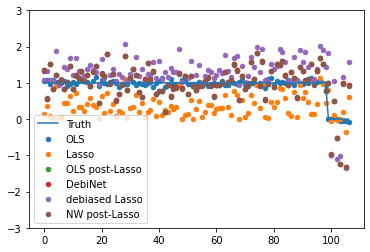



OLS estimation error mean/STD:  0.003349135696931391 0.0004895971032066071
Lasso estimation error mean/STD:  0.45816690473286337 0.020796344345061907
LassoOLS estimation error mean/STD:  0.17472918369050383 0.025007840187942974
dbLasso estimation error mean/STD:  0.2988592594161148 0.035720477171213905
LassoPLM-NN estimation error mean/STD:  0.17465144837489002 0.025063007091166937
LassoPLM-NW estimation error mean/STD:  0.17360222342255668 0.024656428292255818
LassoPLM-Lasso estimation error mean/STD:  0.1520430514286694 0.020699315010409874




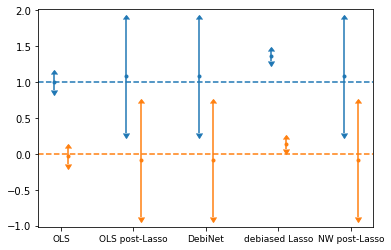



OLS coverage:  0.9546612698316139  with width  0.22775341324787873
LassoOLS coverage:  0.9269761982054652  with width  1.5347426013548315
LassoPLM-NN coverage:  0.9274799226228453  with width  1.5347523236491631
dbLasso coverage:  0.12283681442386518  with width  0.13837551549341537
LassoPLM-NW coverage:  0.9268518900944679  with width  1.5320274733738517
LassoPLM-Lasso coverage:  0.9359829015953501  with width  1.4903072530137131


OLS prediction error mean/STD:  0.3784807786162859 0.030904728730942684
Lasso prediction error mean/STD:  175.8030673636378 3.8463004060795956
LassoOLS prediction error mean/STD:  88.95941748898251 6.313967597525116
dbLasso prediction error:  122.51475724724531 12.222361236406831
LassoPLM-NN prediction error:  88.95318807609998 6.324053266615363
LassoPLM-NW prediction error:  87.13212466850841 6.194783631603898
LassoPLM-Lasso prediction error:  83.77816738962271 6.300727832841805


OLS generalization error mean/STD:  2.625301382039221 0.3132272165055324
L

In [15]:
est_plot(outputs2[0][0][0],outputs2[0][1][0],outputs2[0][2][0],outputs2[0][3][0],outputs2[0][4][0],outputs2[0][5][0],outputs2[0][6][0],outputs2[0][7][0],save='low1.pdf')
print('\n')

### estimation error
ols_record,lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs2[0][0],outputs2[0][1],outputs2[0][2],outputs2[0][3],outputs2[0][4],outputs2[0][5],outputs2[0][6],outputs2[0][7])
print('OLS estimation error mean/STD: ',np.mean(ols_record), np.std(ols_record))
print('Lasso estimation error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS estimation error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso estimation error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN estimation error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW estimation error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso estimation error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

conf_plot(outputs2[2][:-1],save='lowconfidence1.pdf')
print('\n')

### coverage
print('OLS coverage: ',cov_rate(outputs2[2])[0][0],' with width ',cov_rate(outputs2[2])[1][0])
print('LassoOLS coverage: ',cov_rate(outputs2[2])[0][1],' with width ',cov_rate(outputs2[2])[1][1])
print('LassoPLM-NN coverage: ',cov_rate(outputs2[2])[0][2],' with width ',cov_rate(outputs2[2])[1][2])
print('dbLasso coverage: ',cov_rate(outputs2[2])[0][3],' with width ',cov_rate(outputs2[2])[1][3])
print('LassoPLM-NW coverage: ',cov_rate(outputs2[2])[0][4],' with width ',cov_rate(outputs2[2])[1][4])
print('LassoPLM-Lasso coverage: ',cov_rate(outputs2[2])[0][5],' with width ',cov_rate(outputs2[2])[1][5])
print('\n')

### prediction error
ols_record,lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs2[1][0],outputs2[1][1],outputs2[1][2],outputs2[1][3],outputs2[1][4],outputs2[1][5],outputs2[1][6],outputs2[1][7])
print('OLS prediction error mean/STD: ',np.mean(ols_record), np.std(ols_record))
print('Lasso prediction error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS prediction error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso prediction error: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN prediction error: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW prediction error: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso prediction error: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

### generalization error
ols_record,lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs2[4][0],outputs2[4][1],outputs2[4][2],outputs2[4][3],outputs2[4][4],outputs2[4][5],outputs2[4][6],outputs2[4][7])
print('OLS generalization error mean/STD: ',np.mean(ols_record), np.std(ols_record))
print('Lasso generalization error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS generalization error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso generalization error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN generalization error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW generalization error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso generalization error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

### time
print('LassoPLM-NN time: ',np.mean(outputs2[3][0]), np.std(outputs2[3][0]))
print('dbLasso time: ',np.mean(outputs2[3][1]), np.std(outputs2[3][1]))
print('LassoPLM-NW time: ',np.mean(outputs2[3][2]), np.std(outputs2[3][2]))
print('LassoPLM-Lasso time: ',np.mean(outputs2[3][3]), np.std(outputs2[3][3]))


# Low dimension Low Sparsity

In [17]:
start=time.time() # 3min
outputs3=simulations(Nrun=50,split_size=0.2,sigma=1,n=1000,p=500,p1=100,lam=1,alpha=0.05,verbose=0,lamj=1)
print(time.time()-start)

(800, 1) (200, 1)
Run  0 , Lasso selects  38  features.
(800, 1) (200, 1)
Run  1 , Lasso selects  57  features.
(800, 1) (200, 1)
Run  2 , Lasso selects  43  features.
(800, 1) (200, 1)
Run  3 , Lasso selects  53  features.
(800, 1) (200, 1)
Run  4 , Lasso selects  35  features.
(800, 1) (200, 1)
Run  5 , Lasso selects  41  features.
(800, 1) (200, 1)
Run  6 , Lasso selects  31  features.
(800, 1) (200, 1)
Run  7 , Lasso selects  46  features.
(800, 1) (200, 1)
Run  8 , Lasso selects  42  features.
(800, 1) (200, 1)
Run  9 , Lasso selects  39  features.
(800, 1) (200, 1)
Run  10 , Lasso selects  49  features.
(800, 1) (200, 1)
Run  11 , Lasso selects  51  features.
(800, 1) (200, 1)
Run  12 , Lasso selects  45  features.
(800, 1) (200, 1)
Run  13 , Lasso selects  40  features.
(800, 1) (200, 1)
Run  14 , Lasso selects  37  features.
(800, 1) (200, 1)
Run  15 , Lasso selects  28  features.
(800, 1) (200, 1)
Run  16 , Lasso selects  45  features.
(800, 1) (200, 1)
Run  17 , Lasso selects

In [18]:
est_plot(outputs3[0][0][0],outputs3[0][1][0],outputs3[0][2][0],outputs3[0][3][0],outputs3[0][4][0],outputs3[0][5][0],outputs3[0][6][0],outputs3[0][7][0],save='low2.pdf')
print('\n')

### estimation error
ols_record,lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs3[0][0],outputs3[0][1],outputs3[0][2],outputs3[0][3],outputs3[0][4],outputs3[0][5],outputs3[0][6],outputs3[0][7])
print('OLS estimation error mean/STD: ',np.mean(ols_record), np.std(ols_record))
print('Lasso estimation error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS estimation error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso estimation error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN estimation error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW estimation error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso estimation error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

conf_plot(outputs3[2][:-1],save='lowconfidence2.pdf')
print('\n')

### coverage
print('OLS coverage: ',cov_rate(outputs3[2])[0][0],' with width ',cov_rate(outputs3[2])[1][0])
print('LassoOLS coverage: ',cov_rate(outputs3[2])[0][1],' with width ',cov_rate(outputs3[2])[1][1])
print('LassoPLM-NN coverage: ',cov_rate(outputs3[2])[0][2],' with width ',cov_rate(outputs3[2])[1][2])
print('dbLasso coverage: ',cov_rate(outputs3[2])[0][3],' with width ',cov_rate(outputs3[2])[1][3])
print('LassoPLM-NW coverage: ',cov_rate(outputs3[2])[0][4],' with width ',cov_rate(outputs3[2])[1][4])
print('LassoPLM-Lasso coverage: ',cov_rate(outputs3[2])[0][5],' with width ',cov_rate(outputs3[2])[1][5])
print('\n')

### prediction error
ols_record,lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs3[1][0],outputs3[1][1],outputs3[1][2],outputs3[1][3],outputs3[1][4],outputs3[1][5],outputs3[1][6],outputs3[1][7])
print('OLS prediction error mean/STD: ',np.mean(ols_record), np.std(ols_record))
print('Lasso prediction error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS prediction error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso prediction error: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN prediction error: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW prediction error: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso prediction error: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

### generalization error
ols_record,lasso_record,lassols_record,plmnn_record,dblasso_record,plmNW_record,plmlasso_record=est_error_list(outputs3[4][0],outputs3[4][1],outputs3[4][2],outputs3[4][3],outputs3[4][4],outputs3[4][5],outputs3[4][6],outputs3[4][7])
print('OLS generalization error mean/STD: ',np.mean(ols_record), np.std(ols_record))
print('Lasso generalization error mean/STD: ',np.mean(lasso_record), np.std(lasso_record))
print('LassoOLS generalization error mean/STD: ',np.mean(lassols_record), np.std(lassols_record))
print('dbLasso generalization error mean/STD: ',np.mean(dblasso_record), np.std(dblasso_record))
print('LassoPLM-NN generalization error mean/STD: ',np.mean(plmnn_record), np.std(plmnn_record))
print('LassoPLM-NW generalization error mean/STD: ',np.mean(plmNW_record), np.std(plmNW_record))
print('LassoPLM-Lasso generalization error mean/STD: ',np.mean(plmlasso_record), np.std(plmlasso_record))
print('\n')

### time
print('LassoPLM-NN time: ',np.mean(outputs3[3][0]), np.std(outputs3[3][0]))
print('dbLasso time: ',np.mean(outputs3[3][1]), np.std(outputs3[3][1]))
print('LassoPLM-NW time: ',np.mean(outputs3[3][2]), np.std(outputs3[3][2]))
print('LassoPLM-Lasso time: ',np.mean(outputs3[3][3]), np.std(outputs3[3][3]))




OLS estimation error mean/STD:  0.0032720143710454268 0.0006730190735583707
Lasso estimation error mean/STD:  0.6096065338441965 0.03626733975762793
LassoOLS estimation error mean/STD:  0.048249465345362355 0.01419680876674362
dbLasso estimation error mean/STD:  0.10060189052686529 0.026776029647031706
LassoPLM-NN estimation error mean/STD:  0.04823765803586655 0.014270884748271135
LassoPLM-NW estimation error mean/STD:  0.04771935168852279 0.014085377844918012
LassoPLM-Lasso estimation error mean/STD:  0.04694858905116272 0.013855521144341297




/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




OLS coverage:  0.9562342824206472  with width  0.22751465072502186
LassoOLS coverage:  0.9601807190718076  with width  0.9289967180662082
LassoPLM-NN coverage:  0.959507323084117  with width  0.9287285050276579
dbLasso coverage:  0.18552976985253372  with width  0.13824933063299785
LassoPLM-NW coverage:  0.9609955338866224  with width  0.9265532395815541
LassoPLM-Lasso coverage:  0.9614170753688694  with width  0.9225696950044722


OLS prediction error mean/STD:  0.3784807786162859 0.03090472873094281
Lasso prediction error mean/STD:  75.46855694698036 1.7408756564653465
LassoOLS prediction error mean/STD:  40.44251788686898 4.82319274348728
dbLasso prediction error:  66.44268023553168 7.42476414272681
LassoPLM-NN prediction error:  40.40418439883036 4.807716744597554
LassoPLM-NW prediction error:  39.549666617593424 4.729812446259851
LassoPLM-Lasso prediction error:  39.83760751425697 4.807820181069133


OLS generalization error mean/STD:  2.6253013820392215 0.3132272165055352
Lasso

# Save outputs

In [16]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/DPLM/aistats_rebuttal/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pickle
pickle_out = open(path+"outputs_50runs.pickle","wb")
pickle.dump(outputs0, pickle_out)
pickle.dump(outputs1, pickle_out)
pickle.dump(outputs2, pickle_out)
pickle.dump(outputs3, pickle_out)
pickle_out.close()

# Load outputs

In [18]:
from google.colab import drive
import pickle
drive.mount('/content/drive')
path = '/content/drive/My Drive/DPLM/aistats_rebuttal/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
pickle_out = open(path+"outputs_50runs.pickle","rb")
outputs0 = pickle.load(pickle_out) #HH
outputs1 = pickle.load(pickle_out) #HL
outputs2 = pickle.load(pickle_out) #LH
outputs3 = pickle.load(pickle_out) #LL
pickle_out.close()